In [1]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [130]:
def load_raw_data(txt_filename: str) -> pd.DataFrame:
    """ Loads the .txt data from the Data folder as pandas DataFrame 
        :argument: txt_filename - name of the text file with .txt extension
        :return: dataframe - pandas DataFrame
    """
    # Define the data folder path
    data_path = Path().absolute().parent.joinpath('data', 'raw')
    # Open with pandas without header and space as separator
    train = pd.read_csv(data_path.joinpath(txt_filename), sep='\s+', header=None).dropna(axis=1, how='all')
    test = pd.read_csv(data_path.joinpath(txt_filename.replace('train', 'test')), sep='\s+', header=None).dropna(axis=1, how='all')
    y_test = pd.read_csv(data_path.joinpath(txt_filename.replace('train', 'RUL')), sep='\s+', header=None, names=['rul']).dropna(axis=1, how='all')
    # Define number of sensor columns
    sensors_number = len(train.columns) - 5
    # Rename the columns to corrensponding value
    column_names = ['unit', 'cycle', 'altitude', 'mach', 'tra'] + [f'sensor_{i}' for i in range(1, sensors_number + 1)]
    train.columns = column_names
    test.columns = column_names
    return train, test, y_test

def create_target(raw_data: pd.DataFrame) -> pd.DataFrame:
    """ Creates the RUL target variable based on max cycles from the dataset 
        :argument: raw_data - Pandas DataFrame containing training data
        :return: dataset - Pandas DataFrame containing training data and target variable
    """
    data = raw_data.copy()
    # Group the data by unit column and calculate the max cycle
    grouped = data.groupby('unit')
    max_cycle = grouped['cycle'].max()
    # Merge the max cycle back to the data
    data = data.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    # Calculate difference between max cycle and current cycle, create RUL
    data['rul'] = data['max_cycle'] - data['cycle']
    # Drop the max cycle column
    data.drop('max_cycle', axis=1, inplace=True)
    return data

def round_conditions(data: pd.DataFrame) -> pd.DataFrame:
    """ Rounds the values of condition columns (altitude, mach, tra) """
    data['altitude'] = data['altitude'].round()
    data['mach'] = data['mach'].round(2)
    data['tra'] = data['tra'].round()
    # Concatenate all 3 conditions into 1
    data['condition'] = data['altitude'] + data['mach'] + data['tra']
    keys = data['condition'].unique()
    mapping = {k: v for k, v in zip(keys, range(1, len(keys) + 1))}
    data['condition'] = data['condition'].map(mapping)
    return data

def standardize(input_data: pd.DataFrame):
    """ Standardizes the sensor values based on condition to have same mean to be comparable """
    data = input_data.copy()
    sensors = [e for e in list(data.columns) if 'sensor_' in e]
    for condition in data['condition'].unique():
        for column in sensors:
            mean =  data.loc[data['condition'] == condition, column].mean()
            std = data.loc[data['condition'] == condition, column].std()
            data.loc[data['condition'] == condition,column] = data.loc[data['condition'] == condition, column].map(lambda x: (x - mean) / (std + 0.0000001))
    return data

def get_condition_stats(data: pd.DataFrame) -> pd.DataFrame:
    """ Computes the Mean and Std for every sensor based on certain condition """
    sensors = [e for e in list(data.columns) if 'sensor_' in e]
    means, stds, conditions = [], [], []
    sensor_names = []
    for condition in data['condition'].unique():
        for column in sensors:
            sensor_names.append(column)
            conditions.append(condition)
            means.append(data.loc[data['condition'] == condition, column].mean())
            stds.append(data.loc[data['condition'] == condition, column].std())
    stats = pd.DataFrame(list(zip(sensor_names, means, stds, conditions)), columns=['sensor_name','mean', 'std', 'condition'])
    return stats

def smooth_data(input_data: pd.DataFrame, window: int) -> pd.DataFrame:
    """ Smooths the sensor measurements with Moving Average and specified window 
        :argument: input_data - Pandas Dataframe containing data
        :argument: window - Integer representing the moving average window size
        :return: smoothed_data - Pandas Dataframe with smoothed sensor measurements
    """
    smoothed_data = input_data.copy()
    sensors = [e for e in list(smoothed_data.columns) if 'sensor_' in e]
    smoothed_data[sensors] = smoothed_data.groupby('unit')[sensors].apply(lambda column: column.rolling(window=window, min_periods=1).mean())
    return smoothed_data

# =========================================================================PLOTTING=============================================================================

def plot_histogram(data: pd.DataFrame, column: str, unit: str = None) -> None:
    """ Plots the histogram for specified column grouped by unit """
    if column == 'rul':
        data = data[['unit', column]].groupby('unit').max().reset_index()
        unit = None
    if unit:
        data = data[data['unit'] == unit]
    data[column].hist(bins=15, figsize=(10,6))
    plt.xlabel(column)
    plt.show()
    
def plot_sensors(input_data: pd.DataFrame, sensor_names: list, unit: str = None, condition: int = None) -> None:
    """ Plots the sensor values for given sensor name over the RUL """
    data = input_data.copy()
    if len(sensor_names) != 4:
        return "Specify 4 sensor names"
    fig, axs = plt.subplots(2, 2, figsize=(20,10))
    if unit and condition:
        data = data[(data['unit'] == unit) & (data['condition'] == condition)]
    elif unit and not condition:
        data = data[data['unit'] == unit]
    elif condition and not unit:
        data = data[data['condition'] == condition]
        max_unit = data['unit'].max()
        random_units = np.random.randint(1, max_unit, size=10)
        print('Random units: ', random_units)
    else:
        max_unit = data['unit'].max()
        random_units = np.random.randint(1, max_unit, size=10)
        print('Random units: ', random_units)
    for i in range(2):
        for j in range(2):
            k = 0
            if i == 1:
                k = 1 
            sensor_name = sensor_names[j+i+k]
            if unit is None:
                for unit_number in random_units.tolist():
                    axs[i,j].plot('rul', sensor_name, data=data[data['unit'] == unit_number])
            else:
                axs[i,j].plot('rul', sensor_name, data=data)
            axs[i,j].set_xlim(300, 0) 
            axs[i,j].set_ylabel(sensor_name)
            axs[i,j].set_xlabel('RUL')
            axs[i,j].set_title(sensor_name)
            axs[i,j].grid(True, linewidth=0.5)
    plt.show()
    
def plot_condition(data: pd.DataFrame, unit: int, cond_column: str) -> None:
    """ Plotting condition values in respect to the RUL (line chart) """
    plt.figure(figsize=(15,5))
    plt.plot('rul', cond_column, '-', data=data[data['unit'] == unit])
    plt.xlim(200,0)
    plt.ylabel(cond_column)
    plt.show()
    
def plot_condition_stats(conditioned_stats: pd.DataFrame, sensor: str) -> None:
    """ Plotting mean values of the specific sensor for all conditions """
    fig, ax1 = plt.subplots(figsize=(12,5))
    # First Y axis (Mean)
    color_1 = 'tab:blue'
    ax1.plot('condition', 'mean', 'o-', data=conditioned_stats[conditioned_stats['sensor_name'] == sensor], color=color_1)
    ax1.set_xlabel('Condition')
    ax1.set_ylabel('Mean', color=color_1)
    ax1.tick_params(axis='y', labelcolor=color_1)
    # Second Y axis (Std)
    ax2 = ax1.twinx() 
    color_2 = 'tab:red'
    ax2.plot('condition', 'std', 'o-', data=conditioned_stats[conditioned_stats['sensor_name'] == sensor], color=color_2)
    ax2.set_ylabel('Std', color=color_2) 
    ax2.tick_params(axis='y', labelcolor=color_2)
    fig.tight_layout() 
    plt.show()
    # Show stats
    print(conditioned_stats[conditioned_stats['sensor_name'] == sensor])
    
def plot_residuals(pred, real) -> None:
    """ Plots the residual errors between the real and predicted value """
    residuals = real - pred
    fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=True, figsize=(20, 8))
    axs[0].scatter(x=pred[::5], y=residuals[::5], color='g', alpha=0.7)
    axs[0].axhline(y=0, linestyle='--', color='black', linewidth=3.5)
    axs[0].set_xlabel('Estimations', fontsize=17)
    axs[0].set_ylabel('Residuals', fontsize=17)
    axs[0].set_title('Estimation residuals\n (Every 5th data point for visibility)', fontsize=18)
    axs[0].tick_params(axis='both', which='major', labelsize=17)
    axs[0].grid()
    axs[1].scatter(x=pred[::5], y=real[::5], c='orange', alpha=0.7)
    axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", c=".1", linewidth=3, label='Best fit')
    axs[1].set_xlabel('Estimations', fontsize=17)
    axs[1].set_ylabel('Real values', fontsize=17)
    axs[1].set_title('Estimation error\n (Every 5th data point for visibility)', fontsize=18)
    axs[1].tick_params(axis='both', which='major', labelsize=17)
    axs[1].set_xlim(min(real), max(real))
    axs[1].set_ylim(min(real), max(real))
    axs[1].grid()
    axs[1].legend(loc='best', fontsize=17)
    plt.show()

In [135]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    """ Evaluates model on both trainig and testing data """
    def _get_metrics(pred, target, metrics_dict: dict) -> dict:
        mse = mean_squared_error(target, pred)
        metrics_dict['MSE'] = mse.round(2)
        rmse = np.sqrt(mse)
        metrics_dict['RMSE'] = rmse.round(2)
        r2 = r2_score(target, pred)
        metrics_dict['R2'] = r2.round(2)
        mae = mean_absolute_error(target, pred)
        metrics_dict['MAE'] = mae.round(2)
        return metrics_dict
    # Predict for both datasets
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    # Calculate metrics
    train_metrics, test_metrics = {'data': 'training'}, {'data': 'test'}
    # Get training metrics
    train_metrics = _get_metrics(train_predict, y_train, train_metrics)
    # Get test metrics
    test_metrics = _get_metrics(test_predict, y_test, test_metrics)
    # Plot the residuals error
    plot_residuals(test_predict, y_test)
    return train_metrics, test_metrics

def define_ml_dataset(train_data: pd.DataFrame, test_data: pd.DataFrame, test_target: pd.DataFrame):
    """ Creates the training and test datasets to train the models 
        :argument: train_data - Pandas DataFrame as training dataset, should contain target RUL
        :argument: test_data - Pandas DataFrame as test dataset, does not contain target RUL
        :argument: y_test - Pandas DataFrame test dataset target RUL
    """
    # Get features and label for training dataset
    x_train = train_data.drop(['cycle', 'rul', 'condition'], axis=1).copy()
    y_train = train_data['rul'].copy()
    # Get features and label for test dataset
    x_test = test_data.drop(['cycle', 'condition'], axis=1).copy()
    # Get only the last row for each of the units/engines because we only have labels for those rows
    x_test = x_test.groupby('unit').last().reset_index().copy()
    y_test = test_target['rul']
    return x_train, y_train, x_test, y_test

def train_baseline(train_data: pd.DataFrame, test_data: pd.DataFrame,  test_target: pd.DataFrame):
    """ Trains the Linear Regression model as a baseline 
        :argument: train_data - Pandas DataFrame as training dataset, should contain target RUL
        :argument: test_data - Pandas DataFrame as test dataset, does not contain target RUL
        :argument: y_test - Pandas DataFrame test dataset target RUL
    """
    # Get features and label for training dataset
    x_train = train_data.drop(['cycle', 'rul', 'condition'], axis=1).copy()
    y_train = train_data['rul'].copy()
    # Get only the last row for each of the units/engines because we only have labels for those rows
    test_grouped = test_data.groupby('unit').last().reset_index().copy()
    # Get features and label for test dataset
    x_test = test_grouped.drop(['cycle', 'condition'], axis=1)
    y_test = test_target['rul']
    # Create Linear Regression model
    model = LinearRegression()
    # Start training
    model.fit(x_train, y_train)
    # Evaluate the trained model
    train_metrics, test_metrics = evaluate_model(model, x_train, y_train, x_test, y_test)
    print(train_metrics)
    print(test_metrics)
    return model, train_metrics, test_metrics

In [125]:
raw_data, test_data, test_target = load_raw_data('train_FD004.txt')
data = create_target(raw_data)
data = round_conditions(data)
test_data = round_conditions(test_data)
standardized_data = standardize(data)
conditioned_stats = get_condition_stats(data)
smoothed_data = smooth_data(standardized_data, window=10)

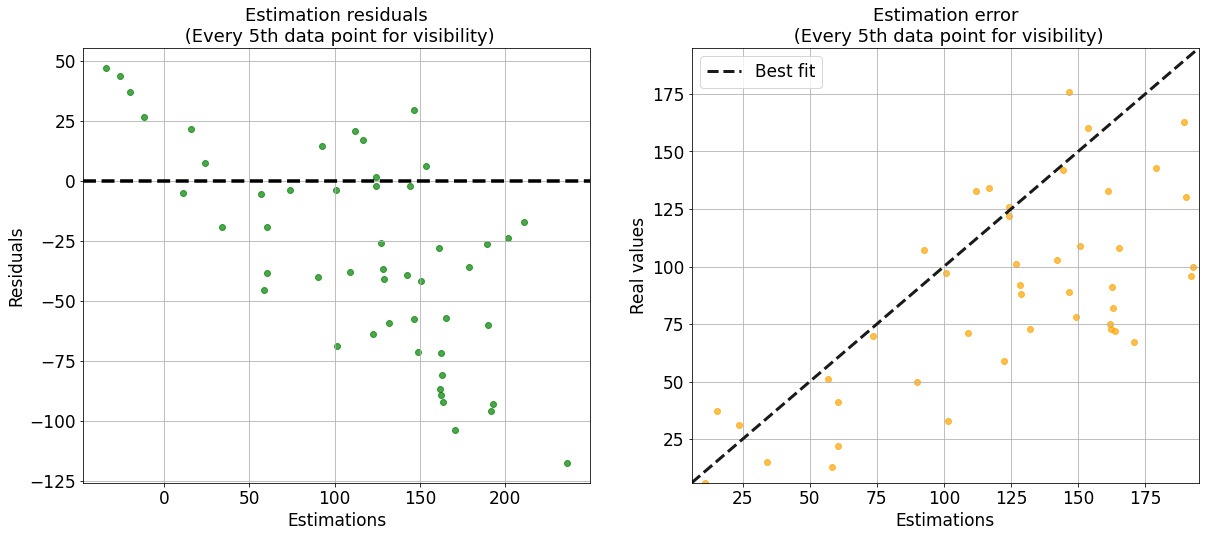

{'data': 'training', 'MSE': 3633.25, 'RMSE': 60.28, 'R2': 0.55, 'MAE': 46.01}
{'data': 'test', 'MSE': 2289.26, 'RMSE': 47.85, 'R2': 0.23, 'MAE': 38.8}


In [136]:
model, train_metrics, test_metrics = train_baseline(data, test_data, test_target)

Random units:  [ 79 121  48 209 150  83   4   5  13 167]


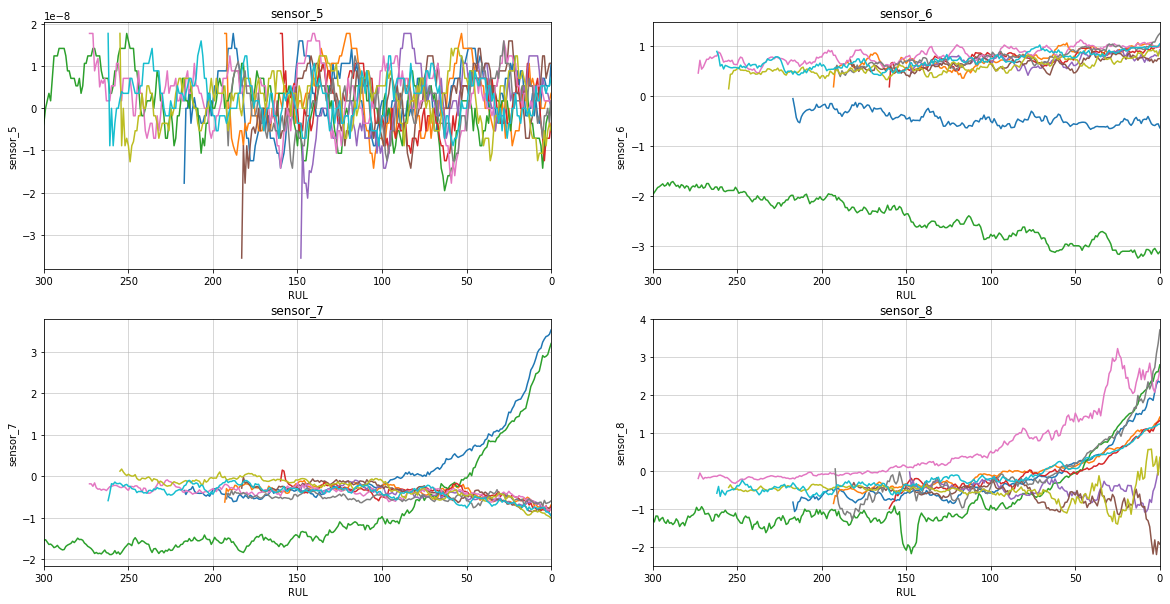

In [6]:
sensors = ['sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']
plot_sensors(smoothed_data, sensors)

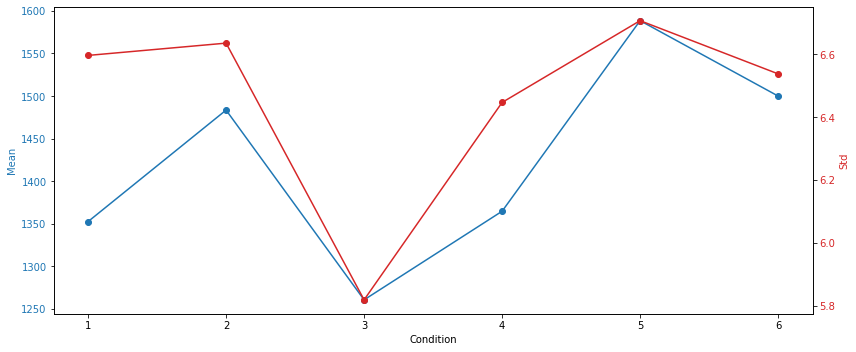

    sensor_name         mean       std  condition
2      sensor_3  1352.562715  6.596366          1
23     sensor_3  1483.501860  6.635482          2
44     sensor_3  1260.672766  5.818127          3
65     sensor_3  1364.709756  6.446601          4
86     sensor_3  1588.519059  6.707031          5
107    sensor_3  1500.003491  6.537669          6


In [124]:
plot_condition_stats(conditioned_stats, sensor='sensor_3')

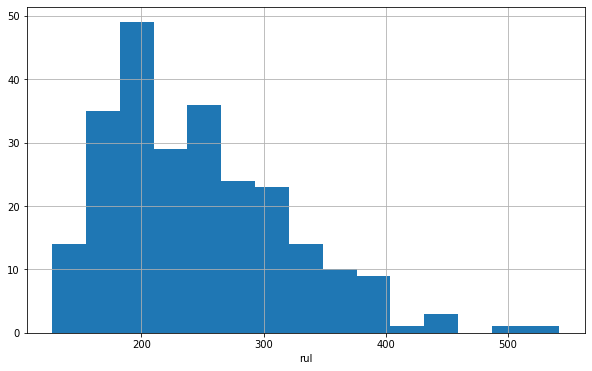

In [4]:
plot_histogram(data, 'rul')

Random units:  [138  19  46 114 234  27 243   3 115 109]


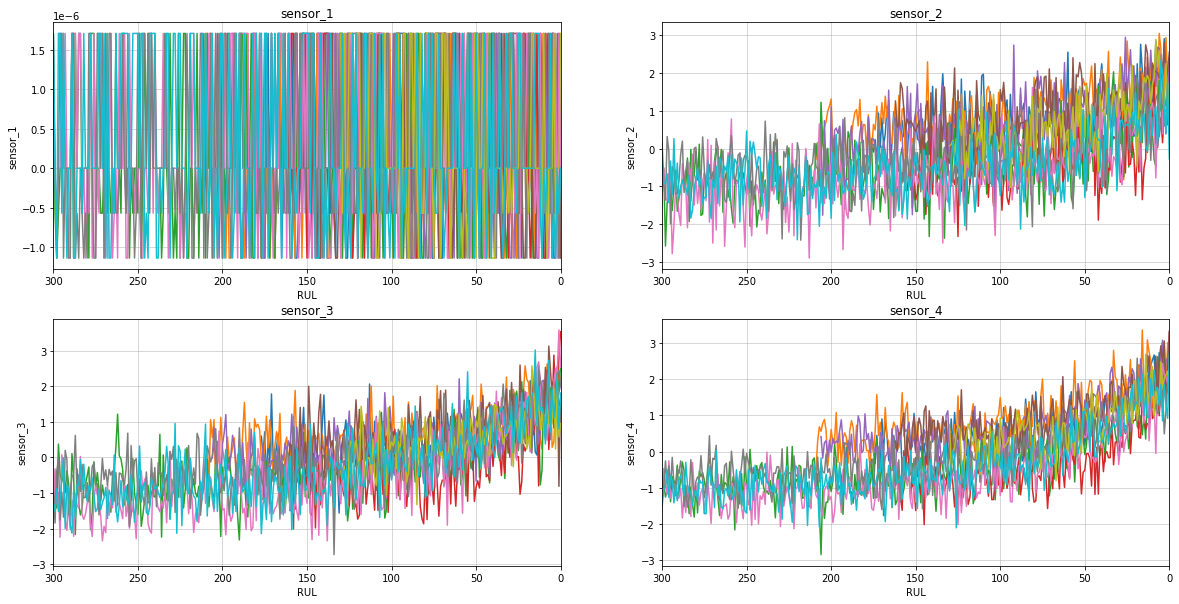

In [23]:
sensors = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']
plot_sensors(standardized_data, sensors)

Random units:  [115  58 231 103 100]


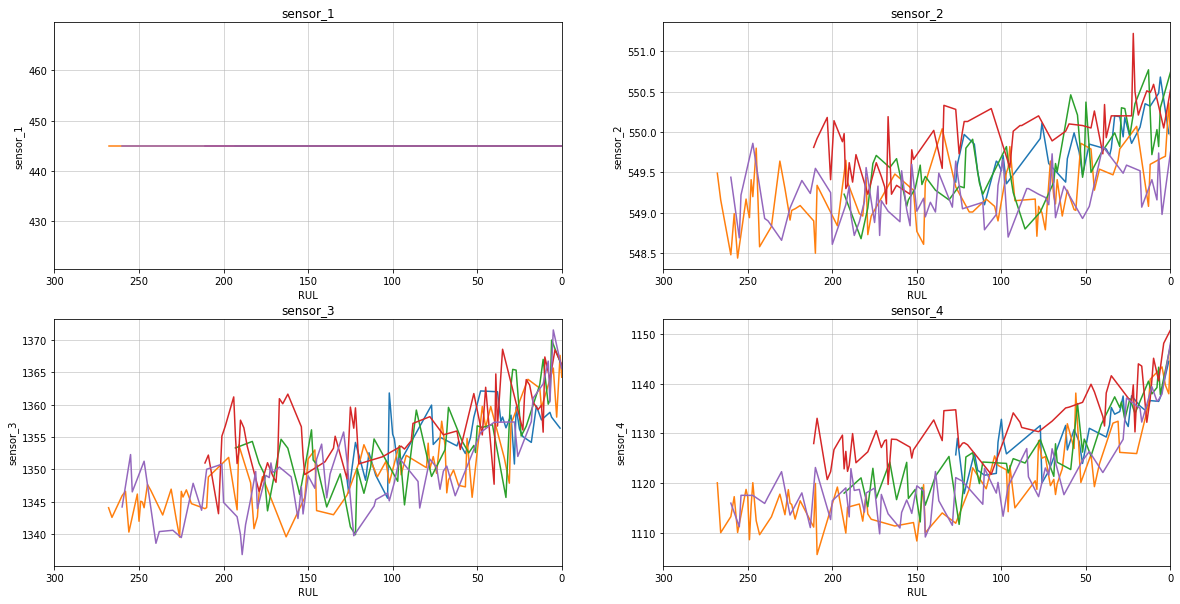

In [59]:
condition = 1
sensors = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']
plot_sensors(data, sensors, condition=condition)

Random units:  [ 38 180  23   8 113]


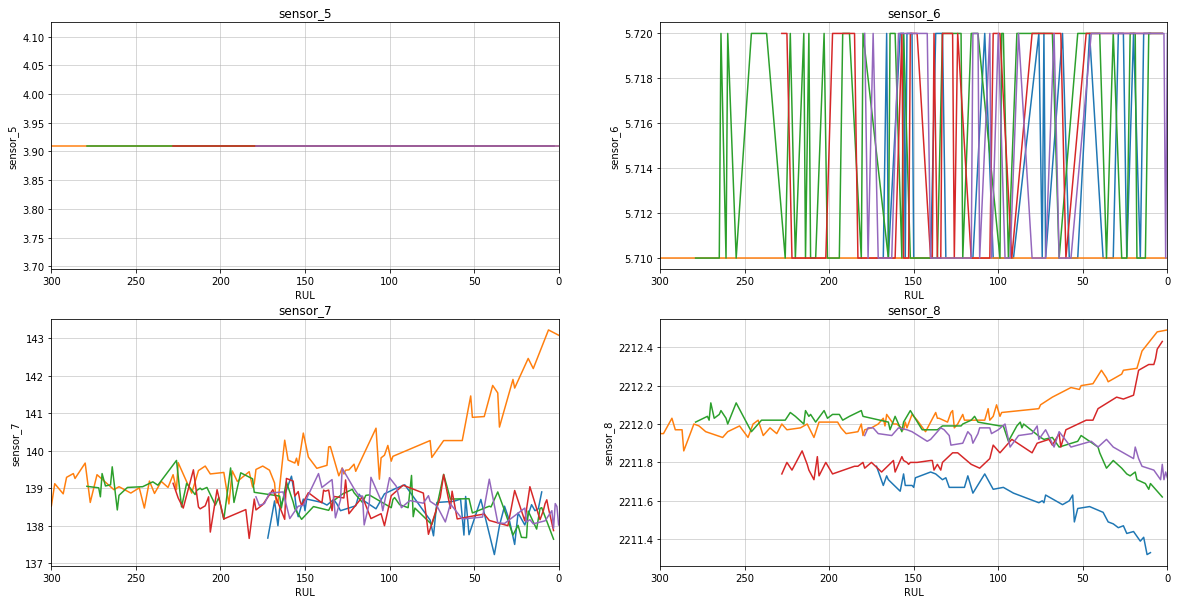

In [60]:
sensors = ['sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']
plot_sensors(data, sensors, condition=condition)

Random units:  [ 61 201  70 161 247]


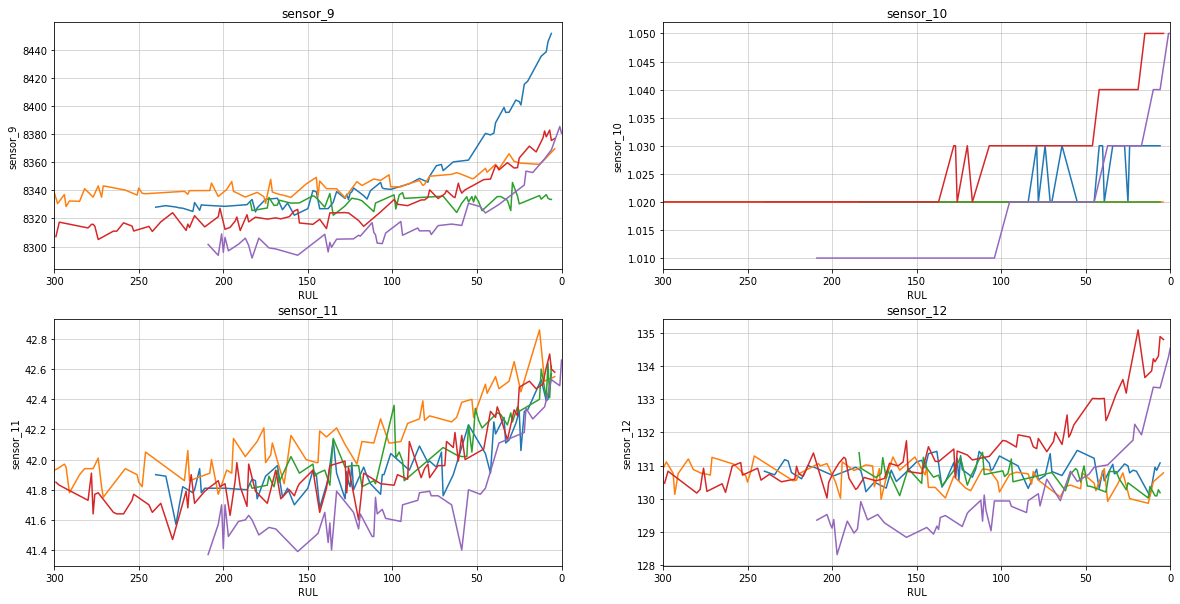

In [61]:
sensors = ['sensor_9', 'sensor_10', 'sensor_11', 'sensor_12']
plot_sensors(data, sensors, condition=condition)

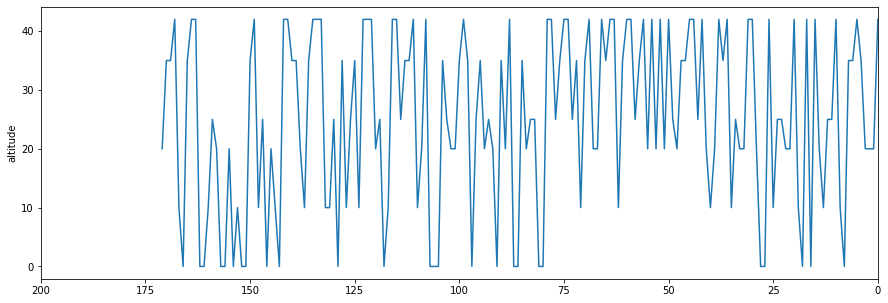

In [65]:
plot_condition(data, unit=50, cond_column='altitude')